In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_convergence
from skopt import gp_minimize

In [3]:
# Importing the composition and properties database
db = pd.read_excel('TiAl_prep-db_2.xlsx')
db = db.iloc[:,1:]
db.head()

,Ti,Al,Mn,Nb,Cr,Mo,V,Zr,Hf,O,...,Ru,Ni,Y,Re,TestT,logYS,logTS,logEl,logHV,logCost
0,53.000,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,298,NaN,NaN,NaN,2.487138,0.582839
1,52.986,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,298,NaN,NaN,NaN,2.472756,0.593444
2,52.486,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,298,NaN,NaN,NaN,2.519828,0.657259
3,52.986,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,298,NaN,NaN,NaN,2.484300,0.593444
4,52.986,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0,0.0,0.0,298,NaN,NaN,NaN,2.510545,0.593444


In [4]:
# information about the database
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ti       1937 non-null   float64
 1   Al       1937 non-null   float64
 2   Mn       1937 non-null   float64
 3   Nb       1937 non-null   float64
 4   Cr       1937 non-null   float64
 5   Mo       1937 non-null   float64
 6   V        1937 non-null   float64
 7   Zr       1937 non-null   float64
 8   Hf       1937 non-null   int64  
 9   O        1937 non-null   float64
 10  Ta       1937 non-null   float64
 11  Si       1937 non-null   float64
 12  W        1937 non-null   float64
 13  C        1937 non-null   float64
 14  B        1937 non-null   float64
 15  Fe       1937 non-null   float64
 16  Ru       1937 non-null   float64
 17  Ni       1937 non-null   int64  
 18  Y        1937 non-null   float64
 19  Re       1937 non-null   float64
 20  TestT    1937 non-null   int64  
 21  logYS    1687 

In [5]:
# Extracting Yield Strength and Vickers Hardness to a new dataframe
df = pd.concat([db.iloc[:,:21],db.iloc[:,23]],axis=1)
df.head()

,Ti,Al,Mn,Nb,Cr,Mo,V,Zr,Hf,O,...,W,C,B,Fe,Ru,Ni,Y,Re,TestT,logEl
0,53.000,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.000,0.0,0.0,0,0.0,0.0,298,NaN
1,52.986,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.014,0.0,0.0,0,0.0,0.0,298,NaN
2,52.486,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.5,0.0,0.014,0.0,0.0,0,0.0,0.0,298,NaN
3,52.986,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.014,0.0,0.0,0,0.0,0.0,298,NaN
4,52.986,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.014,0.0,0.0,0,0.0,0.0,298,NaN


In [6]:
# information about the database
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ti      1937 non-null   float64
 1   Al      1937 non-null   float64
 2   Mn      1937 non-null   float64
 3   Nb      1937 non-null   float64
 4   Cr      1937 non-null   float64
 5   Mo      1937 non-null   float64
 6   V       1937 non-null   float64
 7   Zr      1937 non-null   float64
 8   Hf      1937 non-null   int64  
 9   O       1937 non-null   float64
 10  Ta      1937 non-null   float64
 11  Si      1937 non-null   float64
 12  W       1937 non-null   float64
 13  C       1937 non-null   float64
 14  B       1937 non-null   float64
 15  Fe      1937 non-null   float64
 16  Ru      1937 non-null   float64
 17  Ni      1937 non-null   int64  
 18  Y       1937 non-null   float64
 19  Re      1937 non-null   float64
 20  TestT   1937 non-null   int64  
 21  logEl   485 non-null    float64
dtype

In [7]:
# Droping all the rows with empty Ms and storing into a new dataframe
full_df = df.dropna()
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 485 entries, 8 to 699
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ti      485 non-null    float64
 1   Al      485 non-null    float64
 2   Mn      485 non-null    float64
 3   Nb      485 non-null    float64
 4   Cr      485 non-null    float64
 5   Mo      485 non-null    float64
 6   V       485 non-null    float64
 7   Zr      485 non-null    float64
 8   Hf      485 non-null    int64  
 9   O       485 non-null    float64
 10  Ta      485 non-null    float64
 11  Si      485 non-null    float64
 12  W       485 non-null    float64
 13  C       485 non-null    float64
 14  B       485 non-null    float64
 15  Fe      485 non-null    float64
 16  Ru      485 non-null    float64
 17  Ni      485 non-null    int64  
 18  Y       485 non-null    float64
 19  Re      485 non-null    float64
 20  TestT   485 non-null    int64  
 21  logEl   485 non-null    float64
dtypes:

In [8]:
# Defining the features dataframe
X = full_df.iloc[:,:-1]
X.head()

,Ti,Al,Mn,Nb,Cr,Mo,V,Zr,Hf,O,...,Si,W,C,B,Fe,Ru,Ni,Y,Re,TestT
8,50.5,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.5,2.0,0.0,0.0,0.0,0.0,0,0.0,0.0,298
9,50.5,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.5,2.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1033
10,49.0,46.0,0.0,4.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,298
12,48.3,46.5,0.0,3.0,2.0,0.0,0.0,0.0,0,0.0,...,0.0,0.2,0.0,0.0,0.0,0.0,0,0.0,0.0,298
13,48.3,46.5,0.0,3.0,2.0,0.0,0.0,0.0,0,0.0,...,0.0,0.2,0.0,0.0,0.0,0.0,0,0.0,0.0,1073


In [9]:
# Defining the response dataframe
y = pd.DataFrame(full_df.iloc[:,-1])
y.head()

,logEl
8,0.000000
9,0.397940
10,0.204120
12,0.447158
13,1.602060


In [10]:
# Standard Scaling the features dataframe
scalerX = StandardScaler()

X_transform = pd.DataFrame(scalerX.fit_transform(X), columns = X.columns)

In [11]:
# Standard Scaling the response dataframe
scalerY = StandardScaler()

y_transform = pd.DataFrame(scalerY.fit_transform(y), columns = y.columns)

In [12]:
# Creating an array of feature names
features = X.columns.values
features

array(['Ti', 'Al', 'Mn', 'Nb', 'Cr', 'Mo', 'V', 'Zr', 'Hf', 'O', 'Ta',
       'Si', 'W', 'C', 'B', 'Fe', 'Ru', 'Ni', 'Y', 'Re', 'TestT'],
      dtype=object)

In [13]:
# Creating an array of response names
response = y.columns.values
response

array(['logEl'], dtype=object)

In [95]:
# Splitting the features and response dataframes into training and testing dataframes
X_train, X_test, y_train, y_test = train_test_split(X_transform, y_transform, test_size=0.2, random_state=10)

In [15]:
from sklearn import metrics

# Function to return the mean of the metric for a particular metric name
def metrics_mean(y_ac, y_pred, metric):
    scores = []
    if metric == 'rmse':
        score = round(np.sqrt(metrics.mean_squared_error(y_ac, y_pred)),3)
    elif metric == 'mae':
        score = round(metrics.mean_absolute_error(y_ac, y_pred),3)
    elif metric == 'R2':
        score = round(metrics.r2_score(y_ac, y_pred),3)
    else:
        score = np.inf
    scores.append(score)
    return np.mean(scores)

# Final function "plot" to plot the train-train predicted values, test-test predicted values and the metrics for
# each ML algorithm used
def plot(regressor_name, y_train, y_train_pred, y_test, y_test_pred):

    y_train = scalerY.inverse_transform(y_train)
    y_train_pred = scalerY.inverse_transform(y_train_pred)
    y_test = scalerY.inverse_transform(y_test)
    y_test_pred = scalerY.inverse_transform(y_test_pred)
    
    plt.figure(figsize = (14,6))
    
    # First subplot - training set
    ax1 = plt.subplot(121)
    
    # plot "predicted values vs actual values and true predictions" graph for train set using first prediction
    y_pred_train = pd.DataFrame(y_train_pred)
    plt.scatter(y_train,y_pred_train)
    plt.plot(y_train,y_train,'k--',lw=3)
    
    plt.xlabel('True Value',fontsize=16)
    plt.ylabel('Predicted Value',fontsize=16)
    
    # calculate means of the metrics
    rmse = metrics_mean(y_train,y_pred_train,'rmse')  
    mae = metrics_mean(y_train,y_pred_train,'mae')
    R2 = metrics_mean(y_train,y_pred_train,'R2')
    
    # regressor name with all metrics in the title
    plt.title(regressor_name+' training set'
              +'\nRMSE: '+str(rmse)
              +'\nMAE: '+str(mae)
              +'\nR2: '+str(R2),fontsize=16)
    
    plt.rc('xtick',labelsize=10)
    plt.rc('ytick',labelsize=10)
   
    # Second subplot - test set
    ax2 = plt.subplot(122)
    
    # plot "predicted values vs actual values and true predictions" graph for test set using first prediction
    y_pred_test = pd.DataFrame(y_test_pred)
    plt.scatter(y_test,y_pred_test)
    plt.plot(y_test,y_test,'k--',lw=3)
    
    plt.xlabel('True Value',fontsize=16)
    plt.ylabel('Predicted Value',fontsize=16)
    
    # calculate means of the metrics
    rmse = metrics_mean(y_test,y_pred_test,'rmse')  
    mae = metrics_mean(y_test,y_pred_test,'mae')
    R2 = metrics_mean(y_test,y_pred_test,'R2')
    
    # regressor name with all metrics in the title
    plt.title(regressor_name+' test set'
              +'\nRMSE: '+str(rmse)
              +'\nMAE: '+str(mae)
              +'\nR2: '+str(R2),fontsize=16)
    
    plt.rc('xtick',labelsize=10)
    plt.rc('ytick',labelsize=10)
    
    plt.show()

    # return metrics for test set to record the errors across different algorithms
    return rmse, mae, R2

In [16]:
# Defining empty RMSE, MAE, and R2 dictionaries to store the metrics of each regressor
rmse_scores = {}
mae_scores = {}
R2_scores = {}

In [17]:
# Importing all the regressors used
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


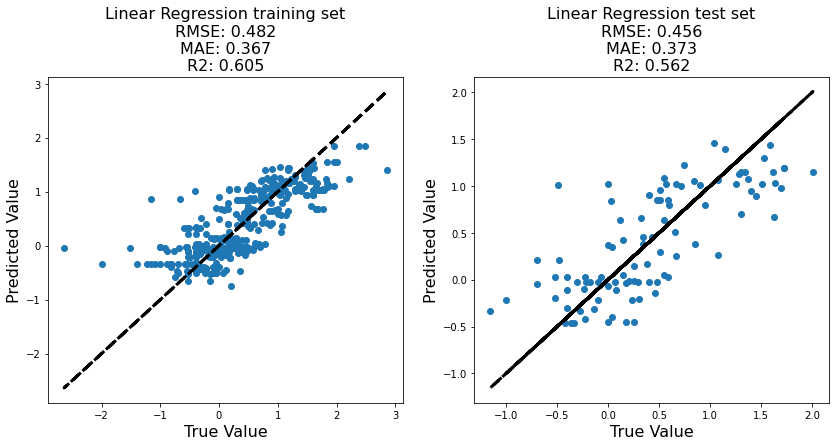

In [96]:
# create a Linear Regression regressor
lregressor = LinearRegression()

# fit and predict all the train/test arrays
lregressor.fit(X_train,y_train)
y_pred_train = lregressor.predict(X_train)
y_pred_test = lregressor.predict(X_test)

# plot the training results
rmse, mae, R2 = plot('Linear Regression', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Linear Regression'] = rmse
mae_scores['Linear Regression'] = mae
R2_scores['Linear Regression'] = R2

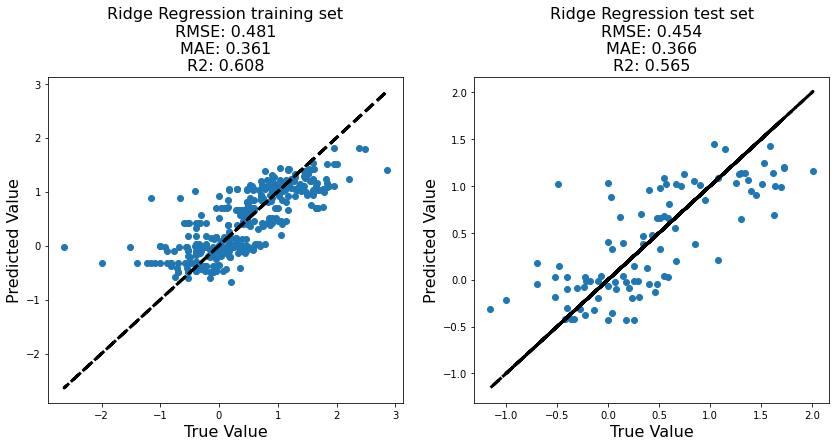

In [97]:
# RidgeCV for best alpha
from sklearn.linear_model import RidgeCV

ridgecv = RidgeCV(alphas = np.logspace(-6,6,104))
ridgecv.fit(X_train, y_train)

# Ridge Regression
rregressor = Ridge(alpha = ridgecv.alpha_)

rregressor.fit(X_train,y_train)
y_pred_train = rregressor.predict(X_train)
y_pred_test = rregressor.predict(X_test)

rmse, mae, R2 = plot('Ridge Regression', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Ridge Regression'] = rmse
mae_scores['Ridge Regression'] = mae
R2_scores['Ridge Regression'] = R2

In [98]:
# Hyperparameter for Ridge Regressor
ridgecv.alpha_

3.3440429337866084

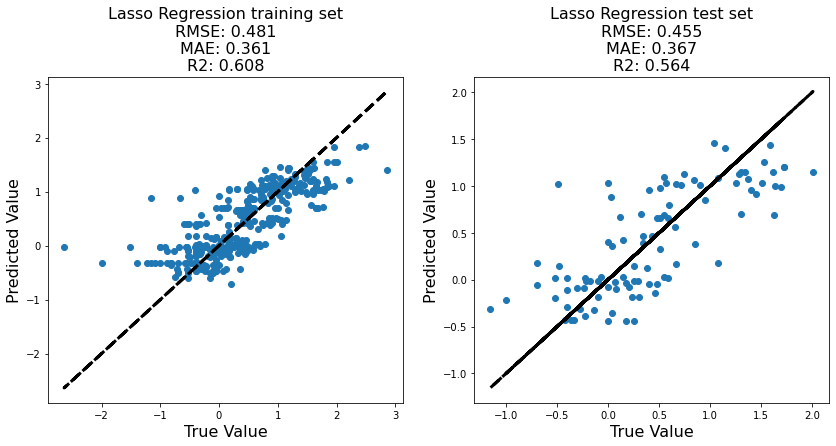

In [99]:
# LassoCV for best alpha
from sklearn.linear_model import LassoCV

y_ravel = y_train.to_numpy().ravel()

lassocv = LassoCV(alphas = np.logspace(-6,6,104))
lassocv.fit(X_train, y_ravel)

# Lasso Regression
lsregressor = Lasso(alpha = lassocv.alpha_)

lsregressor.fit(X_train,y_train)
y_pred_train = lsregressor.predict(X_train).reshape(-1,1)
y_pred_test = lsregressor.predict(X_test).reshape(-1,1)

rmse, mae, R2 = plot('Lasso Regression', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Lasso Regression'] = rmse
mae_scores['Lasso Regression'] = mae
R2_scores['Lasso Regression'] = R2

In [100]:
# Hyperparameter for Lasso Regressor
lassocv.alpha_

0.00036568470503959357

In [104]:
# Hyperparameter optimization of k-Neighbors Regressor
knregressor = KNeighborsRegressor()

knr_space  = [Integer(1, 51, name='n_neighbors'),
              Categorical(categories=['auto', 'brute', 'ball_tree', 'kd_tree'], name='algorithm'),
              Integer(1, 50, name='leaf_size'),
              Integer(1, 11, name='p')]

@use_named_args(knr_space)
def objective(**params):
    knregressor.set_params(**params)
    return -np.mean(cross_val_score(knregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

knr_gp = gp_minimize(objective, knr_space, n_calls=100, n_jobs=-1, random_state=0)

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been

In [105]:
# Hyperparameter of k-Neighbors Regressor
knr_gp.x

[3, 'kd_tree', 1, 11]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

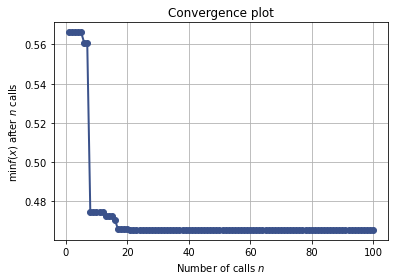

In [106]:
plot_convergence(knr_gp)

array([[<AxesSubplot:xlabel='n_neighbors', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='algorithm'>,
        <AxesSubplot:xlabel='algorithm', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='leaf_size'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='leaf_size', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='n_neighbors', ylabel='p'>,
        <AxesSubplot:xlabel='algorithm'>,
        <AxesSubplot:xlabel='leaf_size'>,
        <AxesSubplot:xlabel='p', ylabel='Partial dependence'>]],
      dtype=object)

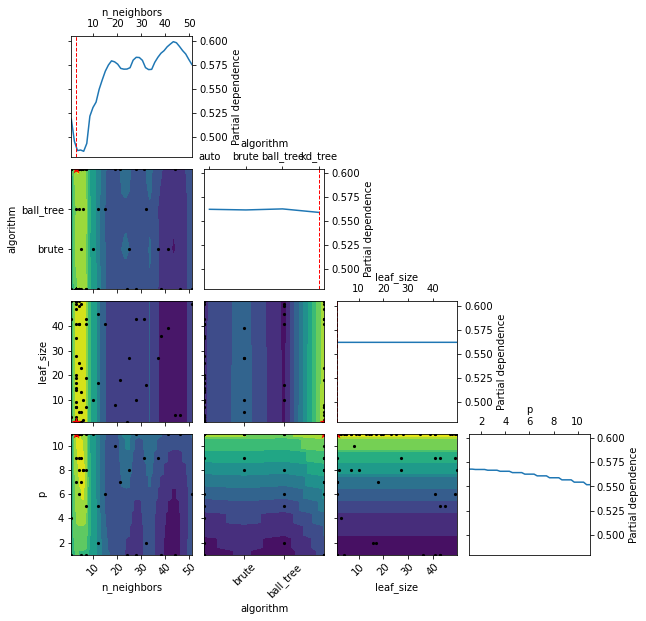

In [107]:
plot_objective(knr_gp)

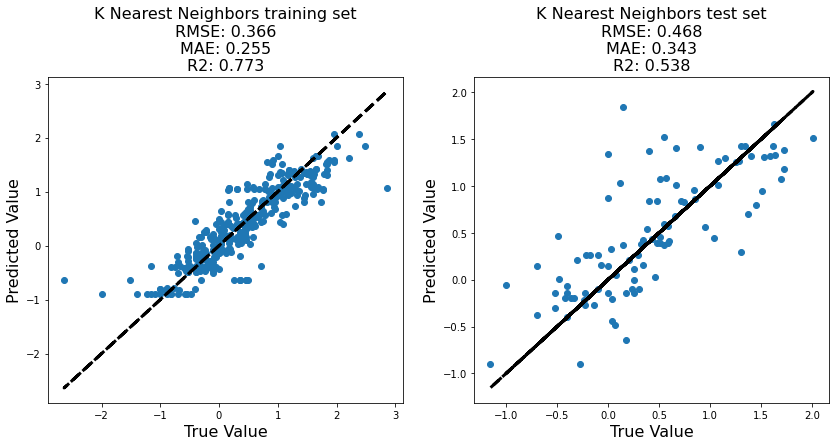

In [108]:
opt_par = knr_gp.x

# use hyper-parameters from optimization 
n_neighbors = opt_par[0]
algorithm = opt_par[1] 
p = opt_par[2]

#K-Nearest Regression
knregressor = KNeighborsRegressor(n_neighbors=n_neighbors,algorithm=algorithm,p=p)

knregressor.fit(X_train,y_train)
y_pred_train = knregressor.predict(X_train)
y_pred_test = knregressor.predict(X_test)

rmse, mae, R2 = plot('K Nearest Neighbors', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['K Nearest Neighbors'] = rmse
mae_scores['K Nearest Neighbors'] = mae
R2_scores['K Nearest Neighbors'] = R2

In [109]:
# Hyperparameter optimization of Support Vector Regressor
svregressor = SVR()

svr_space  = [Categorical(categories=['linear', 'rbf', 'sigmoid'], name='kernel'),
              Real(0.0001, 10, "log-uniform", name='gamma'),
              Real(0.01, 100, name='C')]

@use_named_args(svr_space)
def objective(**params):
    svregressor.set_params(**params)
    return -np.mean(cross_val_score(svregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

svr_gp = gp_minimize(objective, svr_space, n_calls=100, n_jobs=-1, random_state=0)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

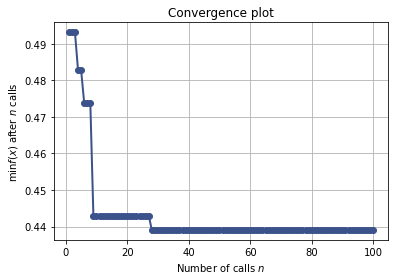

In [110]:
plot_convergence(svr_gp)

array([[<AxesSubplot:xlabel='kernel', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='gamma'>,
        <AxesSubplot:xlabel='gamma', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='kernel', ylabel='C'>,
        <AxesSubplot:xlabel='gamma'>,
        <AxesSubplot:xlabel='C', ylabel='Partial dependence'>]],
      dtype=object)

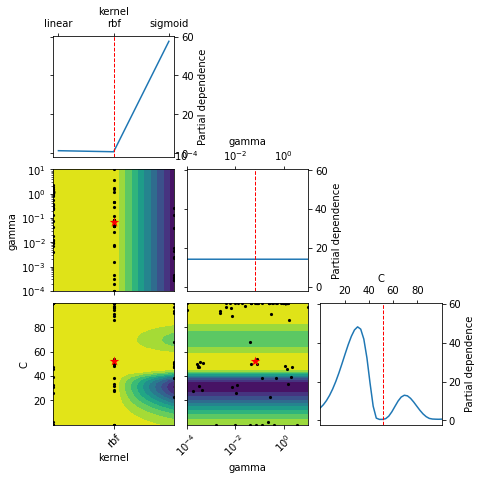

In [111]:
plot_objective(svr_gp)

In [112]:
# Hyperparameter of Support Vector Regressor
svr_gp.x

['rbf', 0.06731576386235916, 51.99693432637387]

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


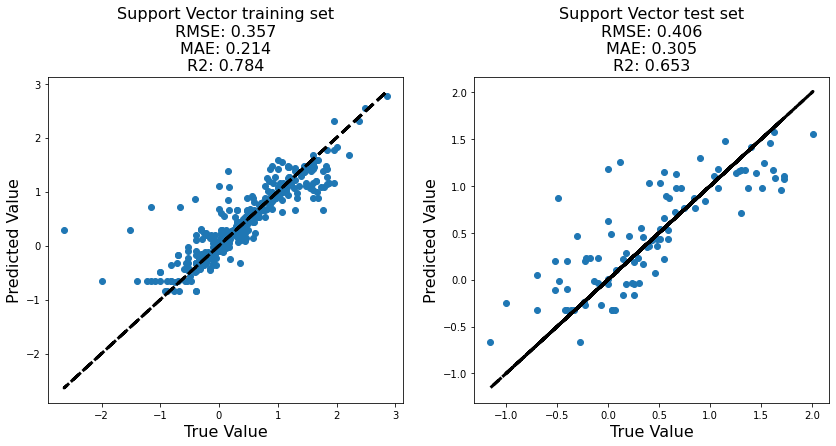

In [113]:
opt_par = svr_gp.x
# use hyper-parameters from optimization 
kernel = opt_par[0]
gamma = opt_par[1]
C = opt_par[2]

# Decision Tree Regression
svregressor = SVR(kernel=kernel, gamma=gamma, C=C)

svregressor.fit(X_train,y_train)
y_pred_train = svregressor.predict(X_train).reshape(-1, 1)
y_pred_test = svregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Support Vector', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Support Vector'] = rmse
mae_scores['Support Vector'] = mae
R2_scores['Support Vector'] = R2

In [114]:
# Hyperparameter optimization of Decision Tree Regressor
dtregressor = DecisionTreeRegressor(random_state=0)

dtr_space  = [Categorical(categories=['squared_error', 'absolute_error', 'friedman_mse'], name='criterion'),
              Categorical(categories=['best', 'random'], name='splitter'),
              Integer(1, 100, name='max_depth')]

@use_named_args(dtr_space)
def objective(**params):
    dtregressor.set_params(**params)
    return -np.mean(cross_val_score(dtregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

dtr_gp = gp_minimize(objective, dtr_space, n_calls=100, n_jobs=-1, random_state=0)

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

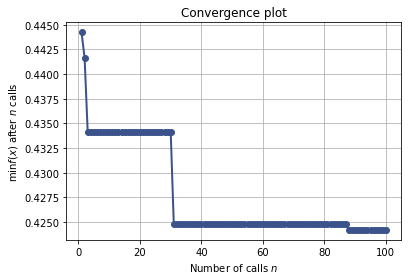

In [115]:
plot_convergence(dtr_gp)

array([[<AxesSubplot:xlabel='criterion', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='splitter'>,
        <AxesSubplot:xlabel='splitter', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='criterion', ylabel='max_depth'>,
        <AxesSubplot:xlabel='splitter'>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>]],
      dtype=object)

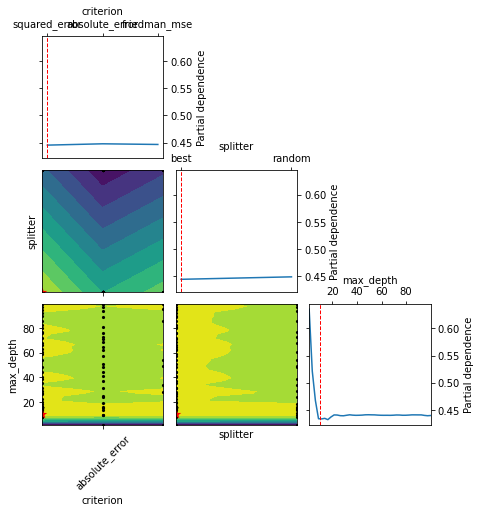

In [116]:
plot_objective(dtr_gp)

In [117]:
# Hyperparameter of Decision Tree Regressor
dtr_gp.x

['squared_error', 'best', 10]

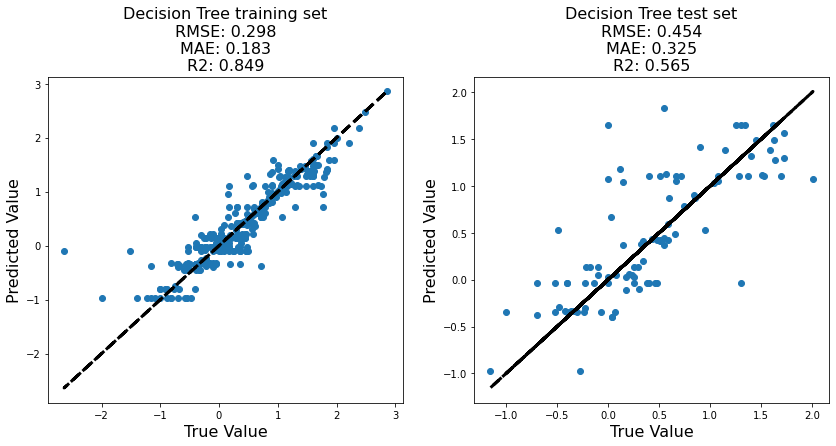

In [118]:
opt_par = dtr_gp.x

# use hyper-parameters from optimization 
criterion = opt_par[0]
splitter = opt_par[1]
max_depth = opt_par[2]

# Decision Tree Regression
dtregressor = DecisionTreeRegressor(criterion=criterion, splitter=splitter, max_depth=max_depth, random_state=0)

dtregressor.fit(X_train,y_train)
y_pred_train = dtregressor.predict(X_train).reshape(-1, 1)
y_pred_test = dtregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Decision Tree', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Decision Tree'] = rmse
mae_scores['Decision Tree'] = mae
R2_scores['Decision Tree'] = R2

In [119]:
# Hyperparameter optimization of Gradient Boosting Regressor
gbregressor = GradientBoostingRegressor(random_state=0)

gbr_space  = [Real(0.005, 0.9, "log-uniform", name='learning_rate'),
              Categorical(categories=['squared_error', 'absolute_error', 'huber', 'quantile'], name='loss'),
              Integer(1, 100, name='n_estimators'),
              Integer(1, 50, name='max_depth'),
              Real(0.005, 0.9, "log-uniform", name='alpha')]

@use_named_args(gbr_space)
def objective(**params):
    gbregressor.set_params(**params)
    return -np.mean(cross_val_score(gbregressor, X_train, y_train.to_numpy().ravel(), cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

gbr_gp = gp_minimize(objective, gbr_space, n_calls=100, n_jobs=-1, random_state=0)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

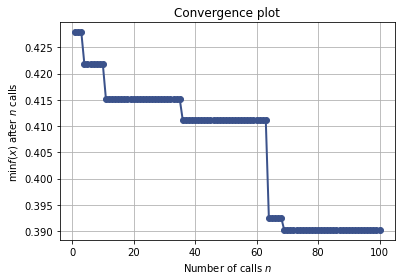

In [120]:
plot_convergence(gbr_gp)

array([[<AxesSubplot:xlabel='learning_rate', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='loss'>,
        <AxesSubplot:xlabel='loss', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='n_estimators'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='n_estimators', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='max_depth'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='learning_rate', ylabel='alpha'>,
        <AxesSubplot:xlabel='loss'>, <AxesSubplot:xlabel='n_estimators'>,
        <AxesSubplot:xlabel='max_depth'>,
        <AxesSubplot:xlabel='alpha', ylabel='Partial dependence'>]],
      dtype=object)

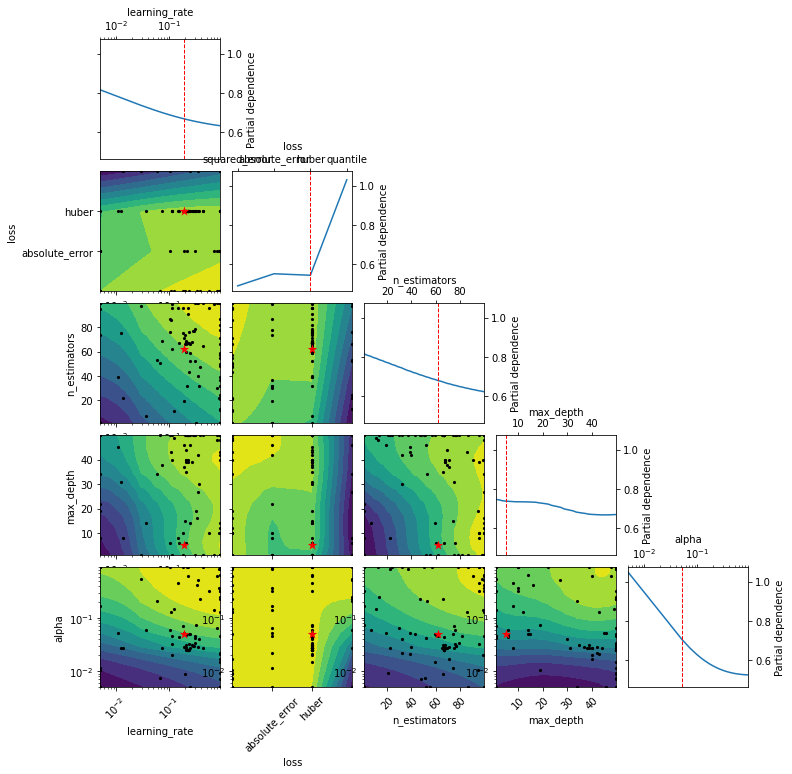

In [121]:
plot_objective(gbr_gp)

In [122]:
# Hyperparameter of Gradient Boosting Regressor
gbr_gp.x

[0.18936705001343404, 'huber', 62, 5, 0.05088290662179969]

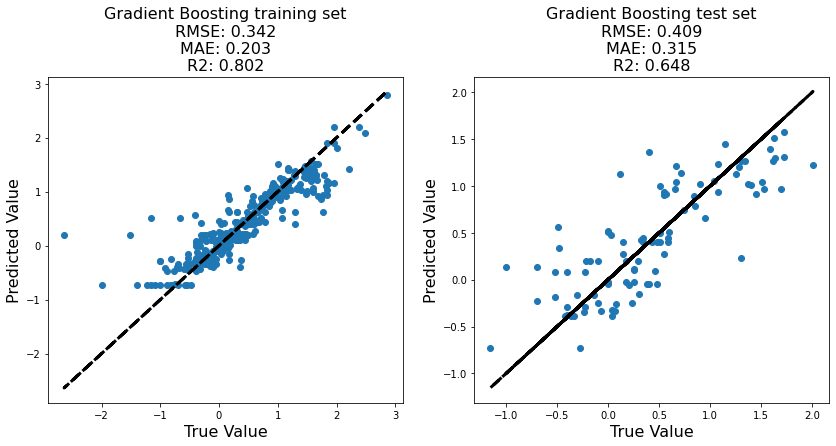

In [123]:
opt_par = gbr_gp.x

# use hyper-parameters from optimization 
learning_rate = opt_par[0]
loss = opt_par[1] 
n_estimators = opt_par[2]
max_depth = opt_par[3]
alpha = opt_par[4]

# Gradient Boosting Regression
gbregressor = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate = learning_rate,
                                        max_depth = max_depth, loss = loss, alpha= alpha, random_state=0)

gbregressor.fit(X_train,y_train.to_numpy().ravel())
y_pred_train = gbregressor.predict(X_train).reshape(-1, 1)
y_pred_test = gbregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Gradient Boosting', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Gradient Boosting'] = rmse
mae_scores['Gradient Boosting'] = mae
R2_scores['Gradient Boosting'] = R2

In [124]:
# Hyperparameter optimization of Random Forest Regressor
rfregressor = RandomForestRegressor(random_state=0)

rfr_space  = [Integer(1, 100, name='n_estimators'),
              Integer(1, 50, name='max_depth')]

@use_named_args(rfr_space)
def objective(**params):
    rfregressor.set_params(**params)
    return -np.mean(cross_val_score(rfregressor, X_train, y_train.to_numpy().ravel(), cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

rfr_gp = gp_minimize(objective, rfr_space, n_calls=100, n_jobs=-1, random_state=0)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

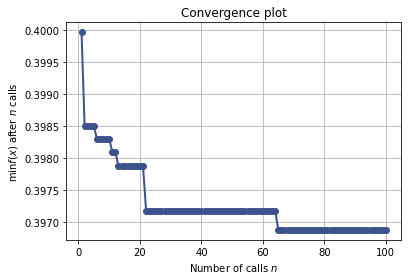

In [125]:
plot_convergence(rfr_gp)

array([[<AxesSubplot:xlabel='n_estimators', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='n_estimators', ylabel='max_depth'>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>]],
      dtype=object)

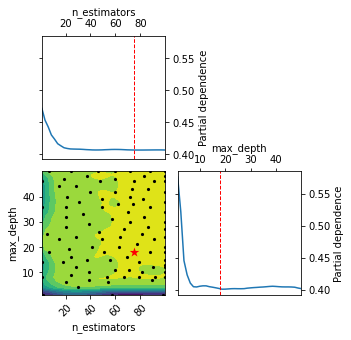

In [126]:
plot_objective(rfr_gp)

In [127]:
# Hyperparameter of Random Forest Regressor
rfr_gp.x

[75, 18]

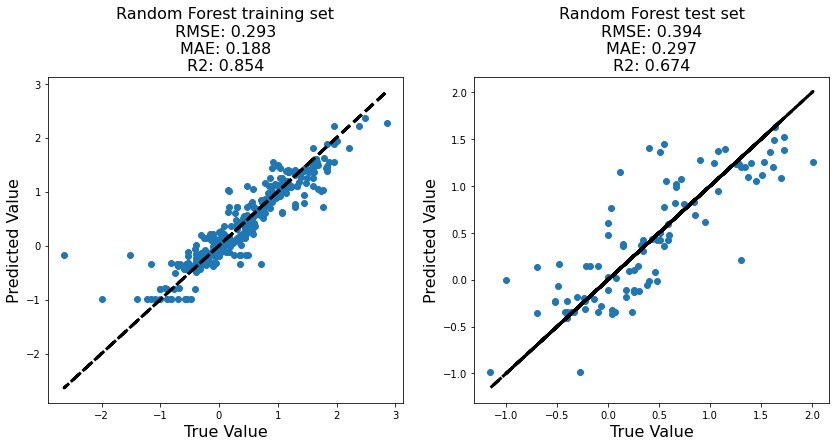

In [128]:
opt_par = rfr_gp.x

# use hyper-parameters from optimization 
n_estimators = opt_par[0]
max_depth = opt_par[1]

# Random Forest Regression
rfregressor = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)

rfregressor.fit(X_train,y_train.to_numpy().ravel())
y_pred_train = rfregressor.predict(X_train).reshape(-1, 1)
y_pred_test = rfregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Random Forest', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Random Forest'] = rmse
mae_scores['Random Forest'] = mae
R2_scores['Random Forest'] = R2

In [129]:
# Hyperparameter optimization of Extra Trees Regressor
etregressor = ExtraTreesRegressor(random_state=0)

etr_space  = [Integer(1, 100, name='n_estimators'),
              Integer(1, 50, name='max_depth')]

@use_named_args(etr_space)
def objective(**params):
    etregressor.set_params(**params)
    return -np.mean(cross_val_score(etregressor, X_train, y_train.to_numpy().ravel(), cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

etr_gp = gp_minimize(objective, etr_space, n_calls=100, n_jobs=-1, random_state=0)

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

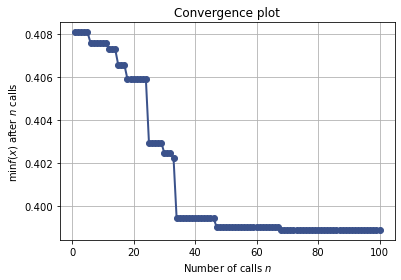

In [130]:
plot_convergence(etr_gp)

array([[<AxesSubplot:xlabel='n_estimators', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='n_estimators', ylabel='max_depth'>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>]],
      dtype=object)

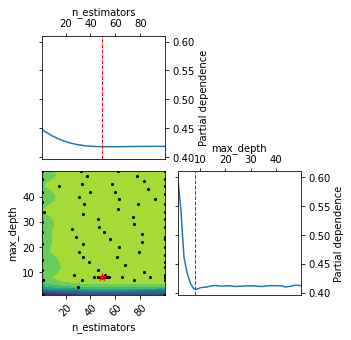

In [131]:
plot_objective(etr_gp)

In [132]:
# Hyperparameter of Extra Trees Regressor
etr_gp.x

[49, 8]

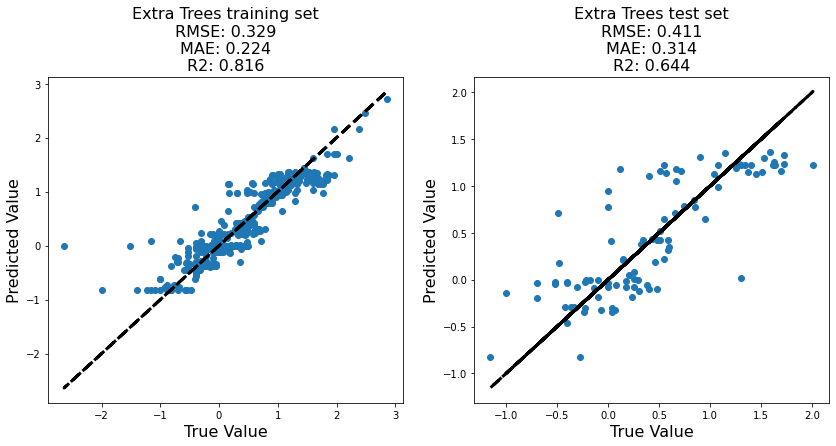

In [133]:
opt_par = etr_gp.x

# use hyper-parameters from optimization 
n_estimators = opt_par[0]
max_depth = opt_par[1]

# Extra Trees Regression
etregressor = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)

etregressor.fit(X_train,y_train.to_numpy().ravel())
y_pred_train = etregressor.predict(X_train).reshape(-1, 1)
y_pred_test = etregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Extra Trees', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Extra Trees'] = rmse
mae_scores['Extra Trees'] = mae
R2_scores['Extra Trees'] = R2

In [134]:
# Hyperparameter optimization of XGBoost Regressor
xgbregressor = XGBRegressor(random_state=0)

xgbr_space  = [Real(0.005, 1, "log-uniform", name='eta'),
              Integer(1, 100, name='n_estimators'),
              Integer(1, 50, name='max_depth'),
              Real(0.1, 1, "log-uniform", name='subsample'),
              Real(0.005, 1, "log-uniform", name='colsample_bytree')]

@use_named_args(xgbr_space)
def objective(**params):
    xgbregressor.set_params(**params)
    return -np.mean(cross_val_score(xgbregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

xgbr_gp = gp_minimize(objective, xgbr_space, n_calls=100, n_jobs=-1, random_state=0)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

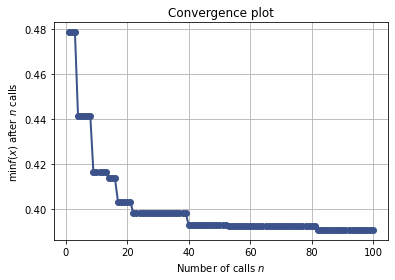

In [135]:
plot_convergence(xgbr_gp)

array([[<AxesSubplot:xlabel='eta', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='n_estimators'>,
        <AxesSubplot:xlabel='n_estimators', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='max_depth'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='subsample'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='subsample', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='eta', ylabel='colsample_bytree'>,
        <AxesSubplot:xlabel='n_estimators'>,
        <AxesSubplot:xlabel='max_depth'>,
        <AxesSubplot:xlabel='subsample'>,
        <AxesSubplot:xlabel='colsample_bytree', ylabel='Partial dependence'>]],
      dtype=object)

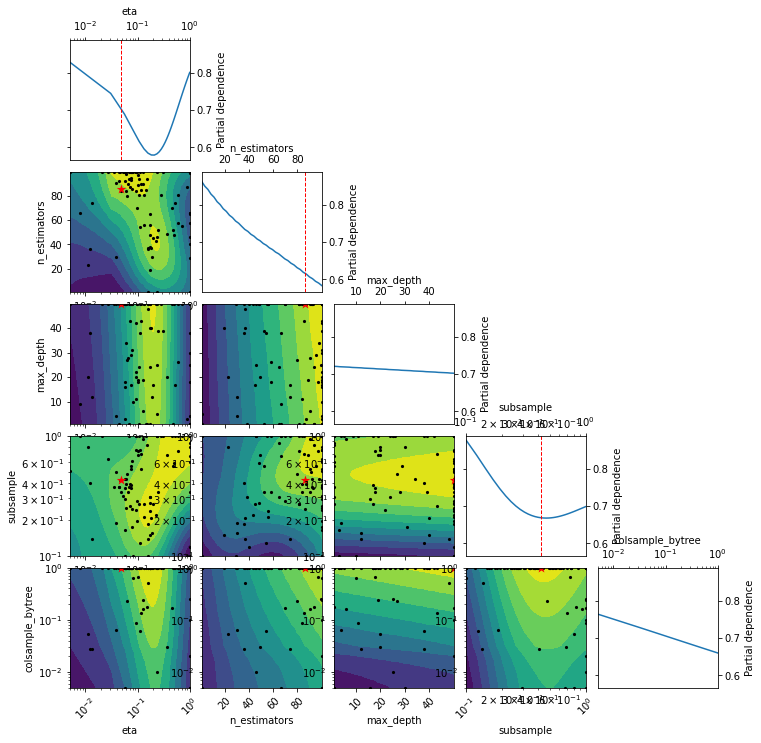

In [136]:
plot_objective(xgbr_gp)

In [137]:
# Hyperparameter of XGBoost Regressor
xgbr_gp.x

[0.047683963730765215, 86, 50, 0.42373520144476257, 1.0]

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


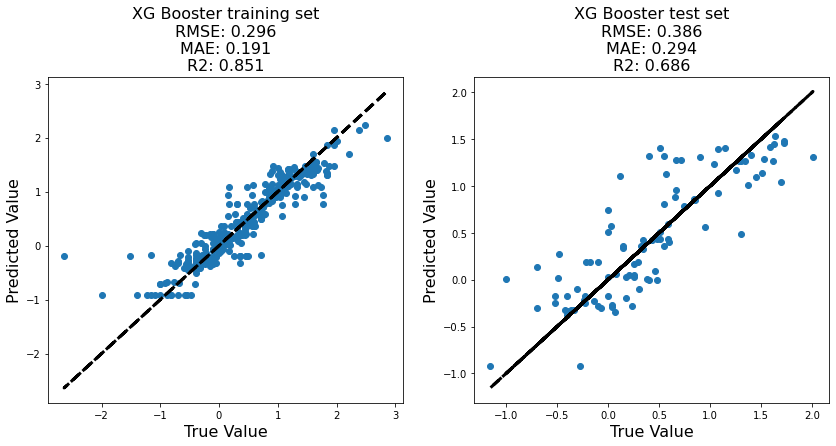

In [138]:
opt_par = xgbr_gp.x

# use hyper-parameters from optimization
eta= opt_par[0]
n_estimators = opt_par[1]
max_depth = opt_par[2]
subsample = opt_par[3]
colsample_bytree = opt_par[4]

#XGBoost Regression
xgbregressor = XGBRegressor(eta=eta, n_estimators=n_estimators, max_depth=max_depth, subsample=subsample,
                            colsample_bytree=colsample_bytree, random_state=0)
    
xgbregressor.fit(X_train,y_train)
y_pred_train = xgbregressor.predict(X_train).reshape(-1, 1)
y_pred_test = xgbregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('XG Booster', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['XG Booster'] = rmse
mae_scores['XG Booster'] = mae
R2_scores['XG Booster'] = R2

In [139]:
# Importing libraries for Neural Network Regression
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras import Sequential
from keras.layers import InputLayer, Dense, BatchNormalization

In [156]:
# Defining Hypermodel object to optimize hyperparameters for Neural Network Regression architecture with same number of units in hidden layers
class MyHyperModel(kt.HyperModel):
    
    def __init__(self,X,y):
        self.X = X
        self.y = y
    
    def build(self, hp):
        num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=5, step=1)
        units = hp.Int('units', min_value=24, max_value=200, step=1)
        activation = hp.Choice('activation', values=['relu', 'elu', 'tanh', 'sigmoid'])
        lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
        optimizer = hp.Choice('optimizer', values=['Adam', 'SGD', 'RMSprop'])
        
        params = dict(num_dense_layers = num_dense_layers,
                      units=units,
                      activation = activation,
                      lr = lr,
                      optimizer=optimizer)
        
        model = Sequential()
        model.add(InputLayer(input_shape=(self.X.shape[1],))) #Input Layer with training feature data shape
        model.add(BatchNormalization())
        for i in range(params['num_dense_layers']):
            name = 'layer_dense_{0}'.format(i+1) #name of hidden layer
            model.add(Dense(units=params['units'],activation=params['activation'], name=name)) #add hidden layer(s)
            model.add(BatchNormalization())
        model.add(Dense(1, activation='linear')) #final layer before output layer
        # 3 types of optimizers are used for finding the best suited with best learning rate
        if params['optimizer'] == 'Adam':
            opt = keras.optimizers.Adam(learning_rate=params['lr'])
        if params['optimizer'] == 'SGD':
            opt = keras.optimizers.SGD(learning_rate=params['lr'])
        if params['optimizer'] == 'RMSprop':
            opt = keras.optimizers.RMSprop(learning_rate=params['lr'])
        model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args,
                         batch_size = hp.Int('batch_size', min_value=8, max_value=64, step=1),
                         #epochs = hp.Int('epochs', min_value=10, max_value=100, step=1),
                         validation_split=0.2,
                         **kwargs,)

In [157]:
# Hyperband Optimization from Keras-Tuner is used for hyperparameter optimization and the complete search space is stored in the working folder
import os
tuner = kt.Hyperband(MyHyperModel(X_train,y_train),
                     objective=kt.Objective("val_loss",direction="min"), max_epochs=200, factor=3,
                     overwrite=True, #in case of reloading the trial runs results
                     directory=os.path.normpath('C:/Users/shakt/Desktop/TiAl_cmp-testT_logEl_Hyb'), project_name='first_run')

In [158]:
tuner.search(X_train, y_train)

Trial 254 Complete [00h 00m 57s]
val_loss: 0.4850693643093109

Best val_loss So Far: 0.39785245060920715
Total elapsed time: 00h 19m 26s
INFO:tensorflow:Oracle triggered exit


In [159]:
tuner.results_summary()

Results summary
Results in C:\Users\shakt\Desktop\TiAl_cmp-testT_logEl_Hyb\first_run
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_dense_layers: 5
units: 174
activation: tanh
learning_rate: 0.00021016888087390355
optimizer: Adam
batch_size: 42
tuner/epochs: 200
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.39785245060920715
Trial summary
Hyperparameters:
num_dense_layers: 2
units: 54
activation: tanh
learning_rate: 0.052057004763565194
optimizer: Adam
batch_size: 63
tuner/epochs: 200
tuner/initial_epoch: 67
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 239d63d9babd43383da09414759494a0
Score: 0.4008508324623108
Trial summary
Hyperparameters:
num_dense_layers: 1
units: 58
activation: tanh
learning_rate: 0.01743978812514076
optimizer: Adam
batch_size: 36
tuner/epochs: 200
tuner/initial_epoch: 67
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: c82765f1d4c18856b9a3daff0ac08004
Score: 0.4125322699546814
Trial summary

In [160]:
# Printing the best hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]

for h_param in ['num_dense_layers', 'units', 'activation', 'learning_rate', 'optimizer', 'batch_size', 'tuner/epochs']:
    print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

num_dense_layers 5
units 174
activation tanh
learning_rate 0.00021016888087390355
optimizer Adam
batch_size 42
tuner/epochs 200


In [161]:
# function to develop NN architecture with same number of units in all hidden layers
num_dense_layers = best_hps.get('num_dense_layers')
units = best_hps.get('units')
activation = best_hps.get('activation')
learning_rate = best_hps.get('learning_rate')
optimizer = best_hps.get('optimizer')
batch_size = best_hps.get('batch_size')
epochs = best_hps.get('tuner/epochs')

In [162]:
# function to plot the training and validation history of the NN
def build_and_compile_model(num_dense_layers,units,activation,lr,optimizer):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],))) #Input Layer with training feature data shape
    model.add(BatchNormalization())
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1) #name of hidden layer
        model.add(Dense(units,activation=activation,name=name)) #add hidden layer(s)
        model.add(BatchNormalization())
    model.add(Dense(1, activation='linear')) #final layer before output layer
    if optimizer == 'Adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    if optimizer == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=lr)
    if optimizer == 'RMSprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
    return model

In [163]:
# Create the neural network with these hyper-parameters.
model1 = build_and_compile_model(num_dense_layers, units, activation, learning_rate, optimizer)

# Train the model.
history = model1.fit(X_train, y_train, epochs=200, batch_size=batch_size, validation_split=0.2, verbose=0)

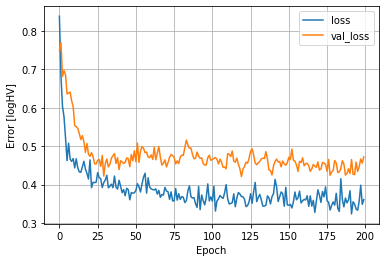

In [164]:
# function to plot the training and validation history of the NN
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [logHV]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [165]:
print('Mean Absolute Error (logEl), Mean Squared Error (logEl): ', model1.evaluate(X_test, y_test, verbose=0))

Mean Absolute Error (logEl), Mean Squared Error (logEl):  [0.43723583221435547, 0.32010143995285034]


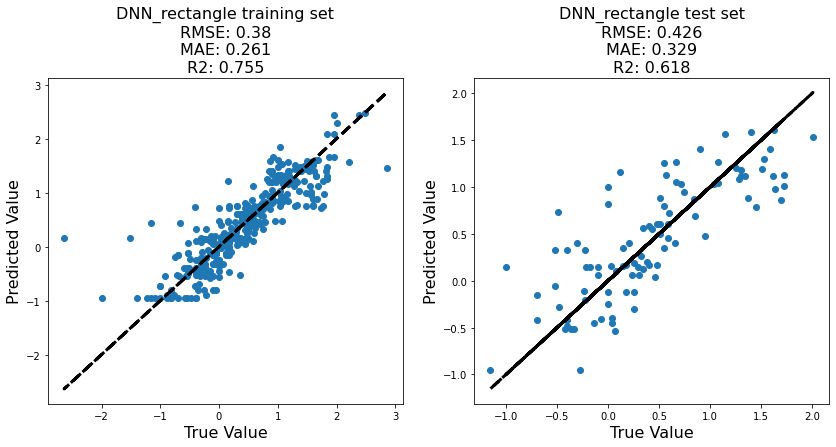

In [166]:
# Use the trained Keras model to predict on the training and test sets
y_pred_train=model1.predict(X_train)
y_pred_test=model1.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('DNN_rectangle', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['DNN_rectangle'] = rmse
mae_scores['DNN_rectangle'] = mae
R2_scores['DNN_rectangle'] = R2

In [167]:
# Defining Hypermodel object to optimize hyperparameters for Neural Network Regression architecture with different number of units in different hidden layers
class MyHyperModel2(kt.HyperModel):
    
    def __init__(self,X,y):
        self.X = X
        self.y = y
    
    def build(self, hp):
        units_1 = hp.Int('units_1', min_value=23, max_value=200, step=1)
        units_2 = hp.Int('units_2', min_value=23, max_value=200, step=1)
        units_3 = hp.Int('units_3', min_value=23, max_value=200, step=1)
        units_4 = hp.Int('units_4', min_value=23, max_value=200, step=1)
        units_5 = hp.Int('units_5', min_value=23, max_value=200, step=1)
        activation = hp.Choice('activation', values=['relu', 'elu', 'tanh', 'sigmoid'])
        lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
        optimizer = hp.Choice('optimizer', values=['Adam', 'SGD', 'RMSprop'])
        
        params = dict(units_1=units_1,
                      units_2=units_2,
                      units_3=units_3,
                      units_4=units_4,
                      units_5=units_5,
                      activation = activation,
                      lr = lr,
                      optimizer=optimizer)
        
        model = Sequential()
        model.add(InputLayer(input_shape=(self.X.shape[1],))) #Input Layer with training feature data shape
        model.add(BatchNormalization())
        # The number of hidden layers are same as previous NN architecture
        model.add(Dense(units=params['units_1'],activation=params['activation'], name='layers_dense_1')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_2'],activation=params['activation'], name='layers_dense_2')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_3'],activation=params['activation'], name='layers_dense_3')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_4'],activation=params['activation'], name='layers_dense_4')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_5'],activation=params['activation'], name='layers_dense_5')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(1, activation='linear')) #final layer before output layer
        # We compile our model with a sampled learning rate.
        if params['optimizer'] == 'Adam':
            opt = keras.optimizers.Adam(learning_rate=params['lr'])
        if params['optimizer'] == 'SGD':
            opt = keras.optimizers.SGD(learning_rate=params['lr'])
        if params['optimizer'] == 'RMSprop':
            opt = keras.optimizers.RMSprop(learning_rate=params['lr'])
        model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args,
                         batch_size = hp.Int('batch_size', min_value=8, max_value=64, step=1),
                         #epochs = hp.Int('epochs', min_value=10, max_value=100, step=1),
                         validation_split=0.2,
                         **kwargs,)

In [168]:
# Hyperband Optimization from Keras-Tuner is used for hyperparameter optimization and the complete search space is stored in the working folder
import os
tuner2 = kt.Hyperband(MyHyperModel2(X_train,y_train),
                     objective=kt.Objective("val_loss",direction="min"), max_epochs=200, factor=3,
                     overwrite=True, #in case of reloading the trial runs results
                     directory=os.path.normpath('C:/Users/shakt/Desktop/TiAl_cmp-testT_logEl_Hyb'), project_name='first_run_random')

In [169]:
tuner2.search(X_train, y_train)

Trial 254 Complete [00h 00m 28s]
val_loss: 0.44137153029441833

Best val_loss So Far: 0.38932740688323975
Total elapsed time: 00h 22m 17s
INFO:tensorflow:Oracle triggered exit


In [170]:
tuner2.results_summary()

Results summary
Results in C:\Users\shakt\Desktop\TiAl_cmp-testT_logEl_Hyb\first_run_random
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units_1: 100
units_2: 74
units_3: 144
units_4: 105
units_5: 124
activation: tanh
learning_rate: 0.008705545212853837
optimizer: SGD
batch_size: 31
tuner/epochs: 200
tuner/initial_epoch: 67
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 65e949002fe6c1d41af1f2b42b70843f
Score: 0.38932740688323975
Trial summary
Hyperparameters:
units_1: 78
units_2: 106
units_3: 38
units_4: 171
units_5: 195
activation: sigmoid
learning_rate: 0.032498689646280866
optimizer: Adam
batch_size: 56
tuner/epochs: 200
tuner/initial_epoch: 67
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 7ea9c2e99c8a7db4b61716f8e01d4ecb
Score: 0.3984372913837433
Trial summary
Hyperparameters:
units_1: 87
units_2: 118
units_3: 184
units_4: 161
units_5: 193
activation: relu
learning_rate: 0.0021861401605933342
optimizer: Adam
batch_size: 63
tun

In [171]:
# Printing the best hyperparameters
best_hps_2=tuner2.get_best_hyperparameters()[0]

for h_param in ['units_1', 'units_2', 'units_3', 'units_4', 'units_5', 'activation', 'learning_rate', 'optimizer', 'batch_size', 'tuner/epochs']:
    print(h_param, tuner2.get_best_hyperparameters()[0].get(h_param))

units_1 100
units_2 74
units_3 144
units_4 105
units_5 124
activation tanh
learning_rate 0.008705545212853837
optimizer SGD
batch_size 31
tuner/epochs 200


In [175]:
# Storing the hyperparameters in variables to develop the NN architecture
units_1 = best_hps_2.get('units_1')
units_2 = best_hps_2.get('units_2')
units_3 = best_hps_2.get('units_3')
units_4 = best_hps_2.get('units_4')
units_5 = best_hps_2.get('units_5')
activation = best_hps_2.get('activation')
learning_rate = best_hps_2.get('learning_rate')
optimizer = best_hps_2.get('optimizer')
batch_size = best_hps_2.get('batch_size')
epochs = best_hps_2.get('tuner/epochs')

In [176]:
# function to develop NN architecture with different number of units in different hidden layers
def compile_model(units_1,units_2,units_3,units_4,units_5,activation,lr,optimizer):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],))) #Input Layer with training feature data shape
    model.add(BatchNormalization())
    name = 'layer_dense_1'#name of hidden layer
    model.add(Dense(units_1, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_2'#name of hidden layer
    model.add(Dense(units_2, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_3'#name of hidden layer
    model.add(Dense(units_3, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_4'#name of hidden layer
    model.add(Dense(units_4, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_5'#name of hidden layer
    model.add(Dense(units_5, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear')) #final layer before output layer
    if optimizer == 'Adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    if optimizer == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=lr)
    if optimizer == 'RMSprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
    return model

In [177]:
# Create the neural network with these hyper-parameters.
model2 = compile_model(units_1,units_2,units_3,units_4,units_5,activation,learning_rate,optimizer)
    
# Train the model.
history = model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

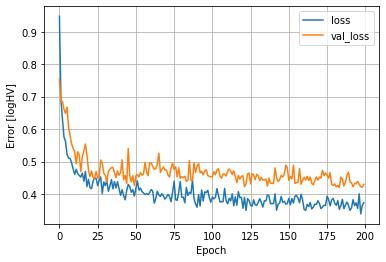

In [178]:
plot_loss(history)

In [179]:
print('Mean Absolute Error (logElong), Mean Squared Error (logElong): ', model2.evaluate(X_test, y_test, verbose=0))

Mean Absolute Error (logElong), Mean Squared Error (logElong):  [0.4512696862220764, 0.3442884683609009]


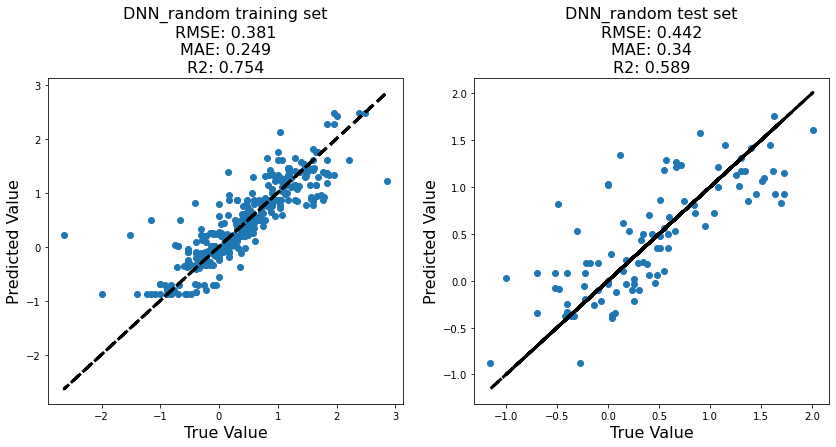

In [180]:
# Use the trained Keras model to predict on the training and test sets
y_pred_train=model2.predict(X_train)
y_pred_test=model2.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('DNN_random', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['DNN_random'] = rmse
mae_scores['DNN_random'] = mae
R2_scores['DNN_random'] = R2

In [181]:
# Creating dataframe of the metrics of the 12 regressors used 
rmse = pd.DataFrame(list(rmse_scores.items()),columns = ['Regressor','RMSE'])
mae = pd.DataFrame(list(mae_scores.items()),columns = ['Regressor','MAE'])
r2 = pd.DataFrame(list(R2_scores.items()),columns = ['Regressor','R2'])
scores_df = pd.concat([rmse,mae.iloc[:,1],r2.iloc[:,1]],axis=1)
scores_df

,Regressor,RMSE,MAE,R2
0,Linear Regression,0.456,0.373,0.562
1,Ridge Regression,0.454,0.366,0.565
2,Lasso Regression,0.455,0.367,0.564
3,K Nearest Neighbors,0.468,0.343,0.538
4,Support Vector,0.406,0.305,0.653
5,Decision Tree,0.454,0.325,0.565
6,Gradient Boosting,0.409,0.315,0.648
7,Random Forest,0.394,0.297,0.674
8,Extra Trees,0.411,0.314,0.644
9,XG Booster,0.386,0.294,0.686


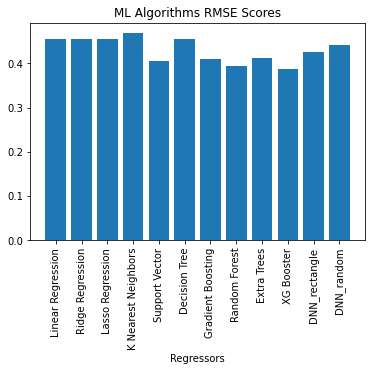

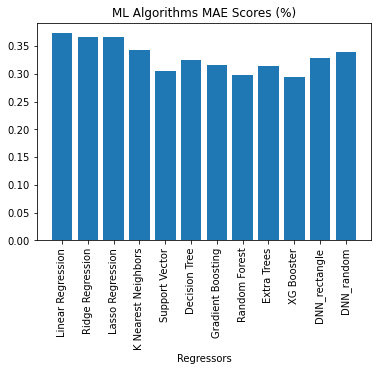

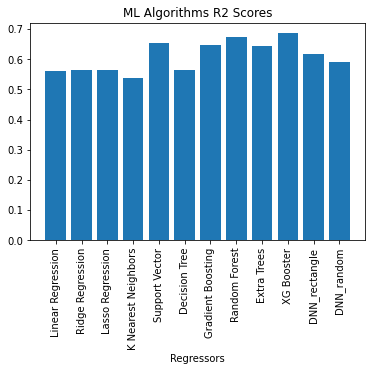

In [182]:
# Plotting the bar graph of the 3 metrics for all the models
plt.bar(range(len(rmse_scores.values())),list(rmse_scores.values()),  
        tick_label=list(rmse_scores.keys()))
plt.xticks(rotation='vertical')
plt.xlabel('Regressors')
plt.title('ML Algorithms RMSE Scores')
plt.show()

plt.bar(range(len(mae_scores.values())),list(mae_scores.values()),  
        tick_label=list(mae_scores.keys()))
plt.xticks(rotation='vertical')
plt.xlabel('Regressors')
plt.title('ML Algorithms MAE Scores (%)')
plt.show()

plt.bar(range(len(R2_scores.values())),list(R2_scores.values()),  
        tick_label=list(R2_scores.keys()))
plt.xticks(rotation='vertical')
plt.xlabel('Regressors')
plt.title('ML Algorithms R2 Scores')
plt.show()

In [183]:
# Exporting the performance metric results
scores_df.to_excel('Scores_comp-testT_logElong.xlsx')

# Imputation

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ti      1937 non-null   float64
 1   Al      1937 non-null   float64
 2   Mn      1937 non-null   float64
 3   Nb      1937 non-null   float64
 4   Cr      1937 non-null   float64
 5   Mo      1937 non-null   float64
 6   V       1937 non-null   float64
 7   Zr      1937 non-null   float64
 8   Hf      1937 non-null   int64  
 9   O       1937 non-null   float64
 10  Ta      1937 non-null   float64
 11  Si      1937 non-null   float64
 12  W       1937 non-null   float64
 13  C       1937 non-null   float64
 14  B       1937 non-null   float64
 15  Fe      1937 non-null   float64
 16  Ru      1937 non-null   float64
 17  Ni      1937 non-null   int64  
 18  Y       1937 non-null   float64
 19  Re      1937 non-null   float64
 20  TestT   1937 non-null   int64  
 21  logEl   485 non-null    float64
dtype

In [185]:
# Predicting HV from TS for all the above indices using the best model
X_imp = df.iloc[:,:-1]
X_transform = scalerX.transform(X_imp)
y_imp_transform = xgbregressor.predict(X_transform)
El_imp = pd.DataFrame(scalerY.inverse_transform(y_imp_transform.reshape(-1,1)),columns=["logEl"])
El_imp = El_imp.round(decimals=2)
El_imp

,logEl
0,0.14
1,0.14
2,-0.14
3,0.14
4,0.14
...,...
1932,-0.21
1933,-0.21
1934,-0.21
1935,-0.21


In [186]:
# Filling up the empty cell with predicted HV values
df.logEl = df.logEl.fillna(El_imp.logEl)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ti      1937 non-null   float64
 1   Al      1937 non-null   float64
 2   Mn      1937 non-null   float64
 3   Nb      1937 non-null   float64
 4   Cr      1937 non-null   float64
 5   Mo      1937 non-null   float64
 6   V       1937 non-null   float64
 7   Zr      1937 non-null   float64
 8   Hf      1937 non-null   int64  
 9   O       1937 non-null   float64
 10  Ta      1937 non-null   float64
 11  Si      1937 non-null   float64
 12  W       1937 non-null   float64
 13  C       1937 non-null   float64
 14  B       1937 non-null   float64
 15  Fe      1937 non-null   float64
 16  Ru      1937 non-null   float64
 17  Ni      1937 non-null   int64  
 18  Y       1937 non-null   float64
 19  Re      1937 non-null   float64
 20  TestT   1937 non-null   int64  
 21  logEl   1937 non-null   float64
dtype

In [187]:
db1 = pd.read_csv('TiAl_prep-db_YS-DNN-RND_TS-final_imp-2.csv')
db1 = db1.iloc[:,1:]
db1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ti       1937 non-null   float64
 1   Al       1937 non-null   float64
 2   Mn       1937 non-null   float64
 3   Nb       1937 non-null   float64
 4   Cr       1937 non-null   float64
 5   Mo       1937 non-null   float64
 6   V        1937 non-null   float64
 7   Zr       1937 non-null   float64
 8   Hf       1937 non-null   int64  
 9   O        1937 non-null   float64
 10  Ta       1937 non-null   float64
 11  Si       1937 non-null   float64
 12  W        1937 non-null   float64
 13  C        1937 non-null   float64
 14  B        1937 non-null   float64
 15  Fe       1937 non-null   float64
 16  Ru       1937 non-null   float64
 17  Ni       1937 non-null   int64  
 18  Y        1937 non-null   float64
 19  Re       1937 non-null   float64
 20  TestT    1937 non-null   int64  
 21  logYS    1937 

In [188]:
# Filling up the empty cells of TS w.r.t to YS with predicted TS values
db1.logEl = db1.logEl.fillna(df.logEl)
db1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ti       1937 non-null   float64
 1   Al       1937 non-null   float64
 2   Mn       1937 non-null   float64
 3   Nb       1937 non-null   float64
 4   Cr       1937 non-null   float64
 5   Mo       1937 non-null   float64
 6   V        1937 non-null   float64
 7   Zr       1937 non-null   float64
 8   Hf       1937 non-null   int64  
 9   O        1937 non-null   float64
 10  Ta       1937 non-null   float64
 11  Si       1937 non-null   float64
 12  W        1937 non-null   float64
 13  C        1937 non-null   float64
 14  B        1937 non-null   float64
 15  Fe       1937 non-null   float64
 16  Ru       1937 non-null   float64
 17  Ni       1937 non-null   int64  
 18  Y        1937 non-null   float64
 19  Re       1937 non-null   float64
 20  TestT    1937 non-null   int64  
 21  logYS    1937 

In [199]:
# Exporting the imputed database by specifying the imputation from YS in the file name
db1.to_csv('TiAl_prep-db_YS-DNN-RND_TS-final_El_imp-3.csv')

In [190]:
db2 = pd.read_csv('TiAl_prep-db_YS-GB_TS-final_imp-2.csv')
db2 = db2.iloc[:,1:]
db2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ti       1937 non-null   float64
 1   Al       1937 non-null   float64
 2   Mn       1937 non-null   float64
 3   Nb       1937 non-null   float64
 4   Cr       1937 non-null   float64
 5   Mo       1937 non-null   float64
 6   V        1937 non-null   float64
 7   Zr       1937 non-null   float64
 8   Hf       1937 non-null   int64  
 9   O        1937 non-null   float64
 10  Ta       1937 non-null   float64
 11  Si       1937 non-null   float64
 12  W        1937 non-null   float64
 13  C        1937 non-null   float64
 14  B        1937 non-null   float64
 15  Fe       1937 non-null   float64
 16  Ru       1937 non-null   float64
 17  Ni       1937 non-null   int64  
 18  Y        1937 non-null   float64
 19  Re       1937 non-null   float64
 20  TestT    1937 non-null   int64  
 21  logYS    1937 

In [191]:
# Filling up the empty cells of TS w.r.t to YS with predicted TS values
db2.logEl = db2.logEl.fillna(df.logEl)
db2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ti       1937 non-null   float64
 1   Al       1937 non-null   float64
 2   Mn       1937 non-null   float64
 3   Nb       1937 non-null   float64
 4   Cr       1937 non-null   float64
 5   Mo       1937 non-null   float64
 6   V        1937 non-null   float64
 7   Zr       1937 non-null   float64
 8   Hf       1937 non-null   int64  
 9   O        1937 non-null   float64
 10  Ta       1937 non-null   float64
 11  Si       1937 non-null   float64
 12  W        1937 non-null   float64
 13  C        1937 non-null   float64
 14  B        1937 non-null   float64
 15  Fe       1937 non-null   float64
 16  Ru       1937 non-null   float64
 17  Ni       1937 non-null   int64  
 18  Y        1937 non-null   float64
 19  Re       1937 non-null   float64
 20  TestT    1937 non-null   int64  
 21  logYS    1937 

In [198]:
# Exporting the imputed database by specifying the imputation from YS in the file name
db2.to_csv('TiAl_prep-db_YS-GB_TS-final_El_imp-3.csv')

In [193]:
db3 = pd.read_csv('TiAl_prep-db_YS-ET_TS-final_imp-2.csv')
db3 = db3.iloc[:,1:]
db3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ti       1937 non-null   float64
 1   Al       1937 non-null   float64
 2   Mn       1937 non-null   float64
 3   Nb       1937 non-null   float64
 4   Cr       1937 non-null   float64
 5   Mo       1937 non-null   float64
 6   V        1937 non-null   float64
 7   Zr       1937 non-null   float64
 8   Hf       1937 non-null   int64  
 9   O        1937 non-null   float64
 10  Ta       1937 non-null   float64
 11  Si       1937 non-null   float64
 12  W        1937 non-null   float64
 13  C        1937 non-null   float64
 14  B        1937 non-null   float64
 15  Fe       1937 non-null   float64
 16  Ru       1937 non-null   float64
 17  Ni       1937 non-null   int64  
 18  Y        1937 non-null   float64
 19  Re       1937 non-null   float64
 20  TestT    1937 non-null   int64  
 21  logYS    1937 

In [194]:
# Filling up the empty cells of TS w.r.t to YS with predicted TS values
db3.logEl = db3.logEl.fillna(df.logEl)
db3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937 entries, 0 to 1936
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ti       1937 non-null   float64
 1   Al       1937 non-null   float64
 2   Mn       1937 non-null   float64
 3   Nb       1937 non-null   float64
 4   Cr       1937 non-null   float64
 5   Mo       1937 non-null   float64
 6   V        1937 non-null   float64
 7   Zr       1937 non-null   float64
 8   Hf       1937 non-null   int64  
 9   O        1937 non-null   float64
 10  Ta       1937 non-null   float64
 11  Si       1937 non-null   float64
 12  W        1937 non-null   float64
 13  C        1937 non-null   float64
 14  B        1937 non-null   float64
 15  Fe       1937 non-null   float64
 16  Ru       1937 non-null   float64
 17  Ni       1937 non-null   int64  
 18  Y        1937 non-null   float64
 19  Re       1937 non-null   float64
 20  TestT    1937 non-null   int64  
 21  logYS    1937 

In [197]:
# Exporting the imputed database by specifying the imputation from YS in the file name
db3.to_csv('TiAl_prep-db_YS-ET_TS-final_El_imp-3.csv')